In [9]:
# ===== 0. Save Images as HDF5
import os
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import h5py
import random
import pandas as pd
import seaborn as sns

# Utils
start_time = time.time()
def watch_restart():
    global start_time
    start_time = time.time()
def watch_print(title):
    global start_time
    print(title, (time.time() - start_time), 'seconds')

DATA_DIR = 'dataset_raw'
DATASET_FILE = 'dataset.h5'
DATASET_FILE_MINI = 'dataset_mini.h5'
DATASET_FILE_MINI_SIZE = 10000
DATASET_IMAGES = 'images'
DATASET_LABELS = 'labels'
IMAGE_DIMENSION = 224 # VGG16 expects 224 x 224 x 3
LABEL_CLASS = { 'NORMAL': 0, 'CNV': 1, 'DME': 2, 'DRUSEN': 3 }

# 0.1. Get Image Paths and Labels
image_paths = []
image_labels = []
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        path = "{0}/{1}/{2}/{3}".format(
            DATA_DIR,
            os.path.split(os.path.dirname(root))[1], 
            os.path.split(root)[1], 
            file)
        label = LABEL_CLASS[os.path.split(root)[1]]
        image_paths.append(path)
        image_labels.append(label)

watch_print('Get Images Paths and Labels')

Get Images Paths and Labels 0.533203125 seconds


In [11]:
# 0.2. Save Images as HDF5 to read faster for later use (Commented since file only needs to be created only once)
watch_restart()

def create_hdf5(image_paths,
                image_labels,
                image_dimension,
                dataset_file_name,
                dataset_file_size,
                dataset_image_name,
                dataset_label_name):
    with h5py.File(dataset_file_name, 'w') as hf:
        labels = []
        # Create Image Dataset
        hf.create_dataset(dataset_image_name, (dataset_file_size, image_dimension, image_dimension, 3), np.int8)
        # Get random indexes to shuffle
        random_indexes = random.sample(range(0, len(image_paths)), dataset_file_size)
        for index, random_index in enumerate(random_indexes):
            # Read Image
            image = cv2.imread(image_paths[random_index])
            # Resize to a smaller image to compute faster
            image = cv2.resize(image, (image_dimension, image_dimension), interpolation=cv2.INTER_LINEAR)
            # Append Image to HDF5 file
            hf[dataset_image_name][index, ...] = image[None]
            labels.append(image_labels[random_index])
        # Create Label Dataset
        hf.create_dataset(dataset_label_name, (len(labels), ), np.int8)
        hf[dataset_label_name][...] = labels
        
# create_hdf5(image_paths,
#             image_labels,
#             IMAGE_DIMENSION,
#             DATASET_FILE_MINI,
#             DATASET_FILE_MINI_SIZE,
#             DATASET_IMAGES,
#             DATASET_LABELS)
# create_hdf5(image_paths,
#             image_labels,
#             IMAGE_DIMENSION,
#             DATASET_FILE,
#             len(image_paths),
#             DATASET_IMAGES,
#             DATASET_LABELS)

watch_print('Save Images as HDF5')

Save Images as HDF5 0.00029730796813964844 seconds


In [12]:
watch_restart()

# ===== 1. Read Images from HDF5

# Configure Here for different sizes
file_name = DATASET_FILE_MINI # DATASET_FILE     
file_size = DATASET_FILE_MINI_SIZE # len(image_paths)

hf = h5py.File(file_name, 'r')
images = np.array(hf[DATASET_IMAGES]).astype('uint8')
labels = np.array(hf[DATASET_LABELS]).astype('uint8')

watch_print('Read Images from HDF5')

Read Images from HDF5 2.177170991897583 seconds


<class 'numpy.ndarray'>
(10000, 224, 224, 3)


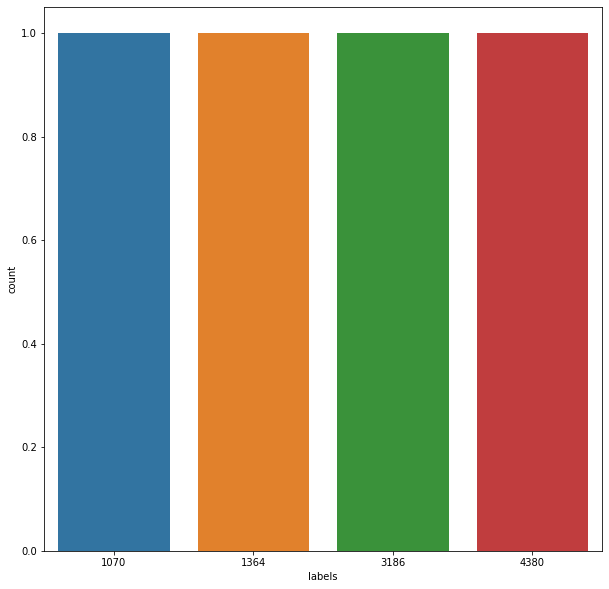

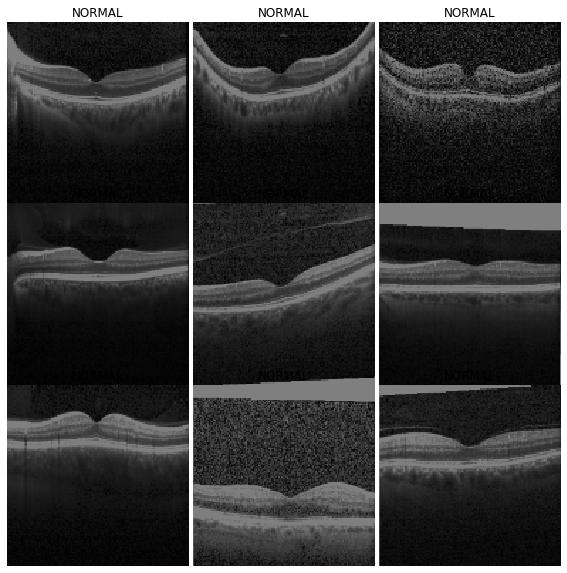

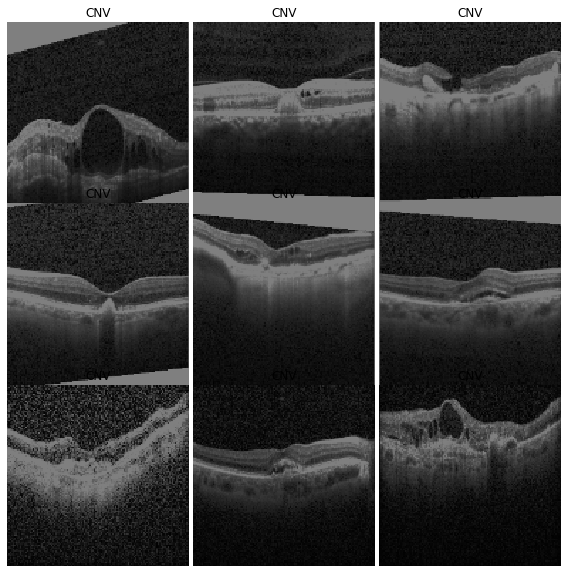

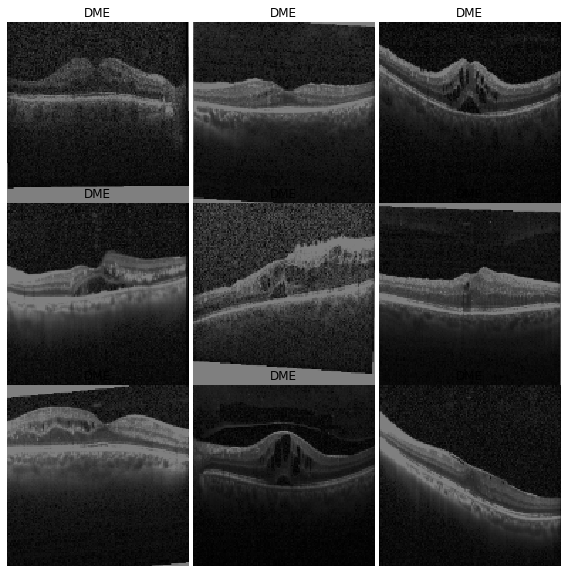

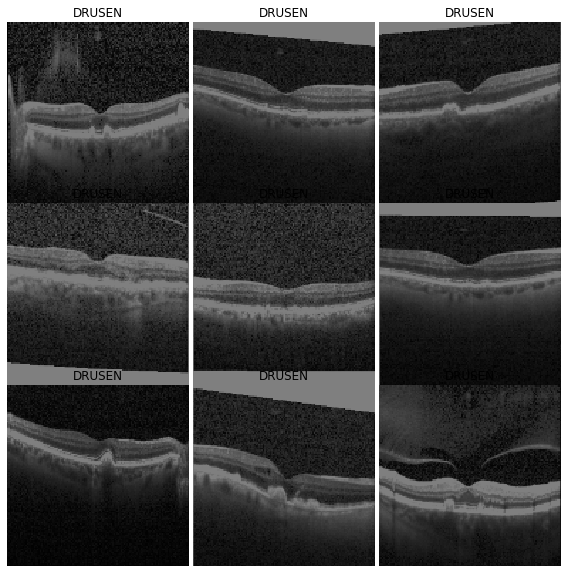

Visualize Images 2.2363197803497314 seconds


In [15]:
watch_restart()

# ===== 2. Visualize Images

print(type(images))
print(images.shape)

df = pd.DataFrame()
df['labels'] = labels
temp = df['labels']
sns.countplot(temp.value_counts())
plt.show()

def images_show(images, title):
    index = 0
    plt.rcParams['figure.figsize'] = (10.0, 10.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    for image in images[:9]:
        im = cv2.resize(image, (128, 128)) 
        plt.subplot(3, 3, index+1)
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); 
        plt.axis('off')
        plt.title(title)
        index += 1
    plt.show()

images_normal = []
images_cnv = []
images_dme = []
images_drusen = []
for index, image in enumerate(images):
    if labels[index] == LABEL_CLASS['NORMAL']:
        images_normal.append(image)
    elif labels[index] == LABEL_CLASS['CNV']:
        images_cnv.append(image)
    elif labels[index] == LABEL_CLASS['DME']:
        images_dme.append(image)
    elif labels[index] == LABEL_CLASS['DRUSEN']:
        images_drusen.append(image)

images_show(images_normal, 'NORMAL')
images_show(images_cnv, 'CNV')
images_show(images_dme, 'DME')
images_show(images_drusen, 'DRUSEN')

watch_print('Visualize Images')